# Monthly Portfolio Rebalancing


In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import numpy as np
import matplotlib.pyplot as plt
import time


In [147]:

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR


def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol


def sharpe(DF, rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr


def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


## Download historical data (monthly) for DJI constituent stocks


In [148]:
tickers = ["MMM", "AXP", "T", "BA", "CAT", "CSCO", "KO", "XOM", "GE", "GS", "HD",
           "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "PFE", "PG", "TRV",
           "UNH", "VZ", "V", "WMT", "DIS"]

ohlc_mon = {}  # directory with ohlc value for each stock
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker, start, end, interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True, how="all")

# redefine tickers variable after removing any tickers with corrupted data
tickers = ohlc_mon.keys()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Backtesting


In [149]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ", ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)


# function to calculate portfolio return iteratively
def pflio(DF, m, x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i, :].mean())
            bad_stocks = df[portfolio].iloc[i, :].sort_values(
                ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i, :].sort_values(
            ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["mon_ret"])
    return monthly_ret_df


# calculating overall strategy's KPIs
CAGR(pflio(return_df, 6, 3))
sharpe(pflio(return_df, 6, 3), 0.025)
max_dd(pflio(return_df, 6, 3))

# calculating KPIs for Index buy and hold strategy over the same period
DJI = yf.download("^DJI", dt.date.today()-dt.timedelta(3650),
                  dt.date.today(), interval='1mo')
DJI["mon_ret"] = DJI["Adj Close"].pct_change().fillna(0)
CAGR(DJI)
sharpe(DJI, 0.025)
max_dd(DJI)


calculating monthly return for  MMM
calculating monthly return for  AXP
calculating monthly return for  T
calculating monthly return for  BA
calculating monthly return for  CAT
calculating monthly return for  CSCO
calculating monthly return for  KO
calculating monthly return for  XOM
calculating monthly return for  GE
calculating monthly return for  GS
calculating monthly return for  HD
calculating monthly return for  IBM
calculating monthly return for  INTC
calculating monthly return for  JNJ
calculating monthly return for  JPM
calculating monthly return for  MCD
calculating monthly return for  MRK
calculating monthly return for  MSFT
calculating monthly return for  NKE
calculating monthly return for  PFE
calculating monthly return for  PG
calculating monthly return for  TRV
calculating monthly return for  UNH
calculating monthly return for  VZ
calculating monthly return for  V
calculating monthly return for  WMT
calculating monthly return for  DIS
['MSFT', 'DIS', 'VZ', 'INTC', 'NKE',

0.23201266165063425

## Visualization


['MSFT', 'DIS', 'VZ', 'INTC', 'NKE', 'MRK']
['MSFT', 'DIS', 'INTC', 'CSCO', 'JPM', 'AXP']
['DIS', 'INTC', 'CSCO', 'UNH', 'BA', 'VZ']
['CSCO', 'UNH', 'BA', 'UNH', 'JNJ', 'GS']
['UNH', 'BA', 'UNH', 'MSFT', 'CAT', 'NKE']
['BA', 'CAT', 'NKE', 'NKE', 'BA', 'V']
['BA', 'BA', 'BA', 'GE', 'AXP', 'VZ']
['AXP', 'JPM', 'MRK', 'UNH', 'MSFT', 'MMM']
['AXP', 'JPM', 'MMM', 'INTC', 'V', 'XOM']
['JPM', 'INTC', 'V', 'MRK', 'CAT', 'MSFT']
['V', 'MRK', 'CAT', 'DIS', 'AXP', 'MRK']
['MRK', 'CAT', 'MRK', 'T', 'MSFT', 'JNJ']
['MRK', 'CAT', 'MRK', 'TRV', 'KO', 'CAT']
['TRV', 'KO', 'VZ', 'CSCO', 'UNH', 'V']
['KO', 'CSCO', 'UNH', 'INTC', 'CAT', 'GS']
['CSCO', 'INTC', 'GS', 'INTC', 'IBM', 'MSFT']
['GS', 'MSFT', 'HD', 'CAT', 'PG', 'UNH']
['GS', 'MSFT', 'PG', 'NKE', 'JNJ', 'GS']
['PG', 'NKE', 'V', 'UNH', 'MMM', 'TRV']
['PG', 'NKE', 'V', 'WMT', 'CSCO', 'INTC']
['PG', 'V', 'CSCO', 'HD', 'JPM', 'GS']
['V', 'CSCO', 'HD', 'BA', 'MRK', 'UNH']
['CSCO', 'HD', 'UNH', 'DIS', 'JPM', 'CSCO']
['HD', 'UNH', 'DIS', 'UNH', 'NKE', 

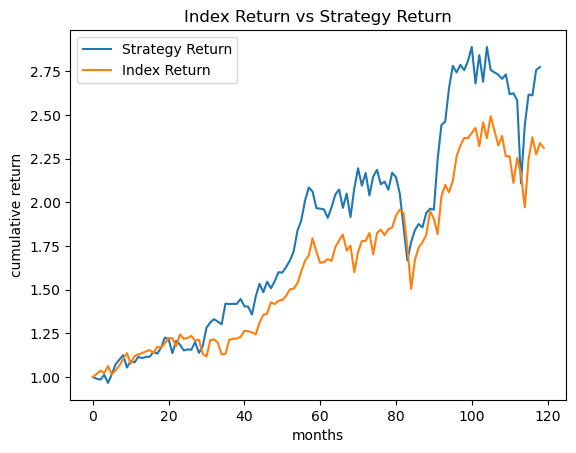

In [150]:
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df, 6, 3)).cumprod())
plt.plot((1+DJI["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return", "Index Return"])


# Resistance Breakout


In [151]:

def ATR(DF, n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)
    return df2['ATR']


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR


def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol


def sharpe(DF, rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr


def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [152]:
tickers = ["ADANIPORTS.NS", "ADANIENT.NS", "ADANIGREEN.NS",
           "ADANIPOWER.NS", "HDFCBANK.NS", "ICICIBANK.NS", "DMART.NS"]


ohlc_intraday = {}  # directory with ohlc value for each stock


# start_time = time.time()
for ticker in tickers:
    data = yf.download(ticker, period='1mo', interval="5m")
    # remove data outside regular trading hours
    data = data.between_time('09:35', '16:00')
    ohlc_intraday[ticker] = data


# redefine tickers variable after removing any tickers with corrupted data
tickers = ohlc_intraday.keys()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe


In [153]:
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("calculating ATR and rolling max price for ", ticker)
    ohlc_dict[ticker]["signal"] = ''
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker], 20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(
        20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(
        20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(
        20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = [0]


calculating ATR and rolling max price for  ADANIPORTS.NS
calculating ATR and rolling max price for  ADANIENT.NS
calculating ATR and rolling max price for  ADANIGREEN.NS
calculating ATR and rolling max price for  ADANIPOWER.NS
calculating ATR and rolling max price for  HDFCBANK.NS
calculating ATR and rolling max price for  ICICIBANK.NS
calculating ATR and rolling max price for  DMART.NS


In [154]:
tickers_signal


{'ADANIPORTS.NS': '',
 'ADANIENT.NS': '',
 'ADANIGREEN.NS': '',
 'ADANIPOWER.NS': '',
 'HDFCBANK.NS': '',
 'ICICIBANK.NS': '',
 'DMART.NS': ''}

In [155]:
ohlc_dict['ADANIENT.NS']


,Open,High,Low,Close,Adj Close,Volume,signal,ATR,roll_max_cp,roll_min_cp,roll_max_vol
Datetime,,,,,,,,,,,
2023-01-11 11:15:00+05:30,3596.250000,3598.899902,3591.600098,3594.000000,3594.000000,8193,,13.272498,3637.899902,3578.850098,69017.0
2023-01-11 11:20:00+05:30,3592.949951,3596.000000,3586.000000,3589.250000,3589.250000,14647,,13.007495,3637.899902,3578.850098,69017.0
2023-01-11 11:25:00+05:30,3588.850098,3597.000000,3582.850098,3595.000000,3595.000000,15637,,13.212488,3637.899902,3578.850098,69017.0
2023-01-11 11:30:00+05:30,3596.850098,3597.000000,3584.000000,3586.050049,3586.050049,14198,,13.314990,3637.899902,3578.850098,69017.0
2023-01-11 11:35:00+05:30,3586.000000,3592.199951,3584.000000,3584.050049,3584.050049,7976,,12.614990,3626.850098,3578.850098,69017.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 15:10:00+05:30,1853.400024,1855.900024,1840.000000,1848.949951,1848.949951,113075,,19.064984,1924.949951,1825.000000,439636.0
2023-02-10 15:15:00+05:30,1848.050049,1871.099976,1847.949951,1854.849976,1854.849976,201205,,19.122485,1924.949951,1825.000000,439636.0
2023-02-10 15:20:00+05:30,1852.650024,1854.650024,1840.150024,1847.949951,1847.949951,215256,,18.339984,1919.849976,1825.000000,439636.0


## Identifying signals and calculating daily return (stop loss factored in)


In [156]:
pd.options.mode.chained_assignment = None

for ticker in tickers:
    print("calculating returns for ", ticker)
    for i in range(1, len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i] >= ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                ohlc_dict[ticker]["signal"][i] = 'buy'
            elif ohlc_dict[ticker]["Low"][i] <= ohlc_dict[ticker]["roll_min_cp"][i] and \
                    ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                ohlc_dict[ticker]["signal"][i] = 'sell'

        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i] < ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(
                    ((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i] <= ohlc_dict[ticker]["roll_min_cp"][i] and \
                    ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                ohlc_dict[ticker]["signal"][i] = 'sell'
                tickers_ret[ticker].append(
                    (ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append(
                    (ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)

        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i] > ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(
                    ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i] >= ohlc_dict[ticker]["roll_max_cp"][i] and \
                    ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                ohlc_dict[ticker]["signal"][i] = 'buy'
                tickers_ret[ticker].append(
                    (ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append(
                    (ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)

    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])


calculating returns for  ADANIPORTS.NS
calculating returns for  ADANIENT.NS
calculating returns for  ADANIGREEN.NS
calculating returns for  ADANIPOWER.NS
calculating returns for  HDFCBANK.NS
calculating returns for  ICICIBANK.NS
calculating returns for  DMART.NS


In [157]:
tickers_signal['ADANIENT.NS']


''

In [158]:
ohlc_dict["ADANIENT.NS"]['signal'][ohlc_dict["ADANIENT.NS"]['signal'] == 'buy']


Datetime
2023-01-11 14:45:00+05:30    buy
2023-01-13 13:00:00+05:30    buy
2023-01-17 15:10:00+05:30    buy
2023-01-24 10:55:00+05:30    buy
2023-01-30 09:40:00+05:30    buy
2023-01-31 13:30:00+05:30    buy
2023-02-06 14:00:00+05:30    buy
2023-02-08 09:40:00+05:30    buy
Name: signal, dtype: object

In [159]:
ohlc_dict["ADANIENT.NS"]['signal'][ohlc_dict["ADANIENT.NS"]['signal'] == 'sell']


Datetime
2023-01-16 09:50:00+05:30    sell
2023-01-16 12:25:00+05:30    sell
2023-01-18 13:55:00+05:30    sell
2023-01-23 12:30:00+05:30    sell
2023-01-25 10:55:00+05:30    sell
2023-01-27 09:35:00+05:30    sell
2023-01-27 11:45:00+05:30    sell
2023-01-27 12:30:00+05:30    sell
2023-01-27 14:50:00+05:30    sell
2023-01-30 13:35:00+05:30    sell
2023-02-01 13:35:00+05:30    sell
2023-02-01 14:10:00+05:30    sell
2023-02-02 12:30:00+05:30    sell
2023-02-03 10:05:00+05:30    sell
2023-02-09 09:45:00+05:30    sell
2023-02-10 14:55:00+05:30    sell
Name: signal, dtype: object

In [160]:
ohlc_dict["ADANIENT.NS"]['signal'][ohlc_dict["ADANIENT.NS"]['signal'] != '']


Datetime
2023-01-11 14:45:00+05:30     buy
2023-01-13 13:00:00+05:30     buy
2023-01-16 09:50:00+05:30    sell
2023-01-16 12:25:00+05:30    sell
2023-01-17 15:10:00+05:30     buy
2023-01-18 13:55:00+05:30    sell
2023-01-23 12:30:00+05:30    sell
2023-01-24 10:55:00+05:30     buy
2023-01-25 10:55:00+05:30    sell
2023-01-27 09:35:00+05:30    sell
2023-01-27 11:45:00+05:30    sell
2023-01-27 12:30:00+05:30    sell
2023-01-27 14:50:00+05:30    sell
2023-01-30 09:40:00+05:30     buy
2023-01-30 13:35:00+05:30    sell
2023-01-31 13:30:00+05:30     buy
2023-02-01 13:35:00+05:30    sell
2023-02-01 14:10:00+05:30    sell
2023-02-02 12:30:00+05:30    sell
2023-02-03 10:05:00+05:30    sell
2023-02-06 14:00:00+05:30     buy
2023-02-08 09:40:00+05:30     buy
2023-02-09 09:45:00+05:30    sell
2023-02-10 14:55:00+05:30    sell
Name: signal, dtype: object

<AxesSubplot:xlabel='Datetime'>

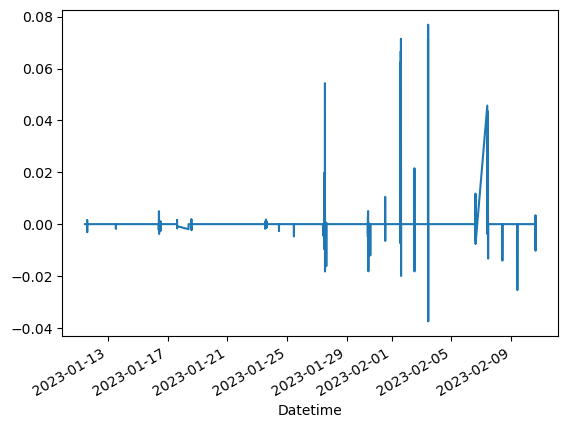

In [161]:
ohlc_dict["ADANIENT.NS"]['ret'].plot()


## Calculating overall strategy's KPIs


In [162]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(sharpe(strategy_df, 0.025))
print(max_dd(strategy_df))


2.7780579394072107
19.70730972124222
0.019971847129333333


## Vizualization of strategy return


<AxesSubplot:xlabel='Datetime'>

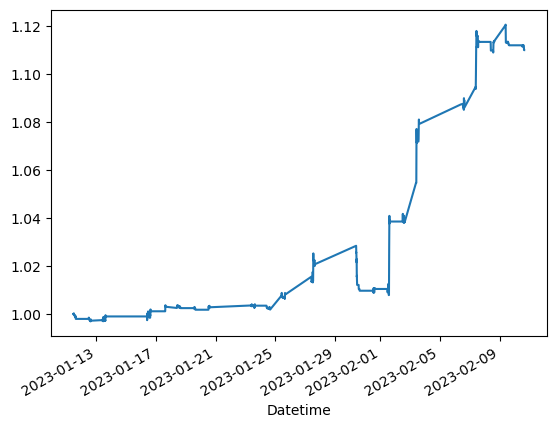

In [163]:
(1+strategy_df["ret"]).cumprod().plot()


## Calculating individual stock's KPIs


In [164]:
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ", ticker)
    cagr[ticker] = CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] = sharpe(ohlc_dict[ticker], 0.025)
    max_drawdown[ticker] = max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr, sharpe_ratios, max_drawdown], index=[
                      "Return", "Sharpe Ratio", "Max Drawdown"])
KPI_df.T


calculating KPIs for  ADANIPORTS.NS
calculating KPIs for  ADANIENT.NS
calculating KPIs for  ADANIGREEN.NS
calculating KPIs for  ADANIPOWER.NS
calculating KPIs for  HDFCBANK.NS
calculating KPIs for  ICICIBANK.NS
calculating KPIs for  DMART.NS


,Return,Sharpe Ratio,Max Drawdown
ADANIPORTS.NS,-0.314333,-1.320125,0.097638
ADANIENT.NS,87.777235,121.397972,0.082052
ADANIGREEN.NS,20.555410,41.686482,0.043723
ADANIPOWER.NS,2.458223,8.675719,0.016199
HDFCBANK.NS,0.042519,0.333350,0.011908
ICICIBANK.NS,0.641260,5.399845,0.010601
DMART.NS,-0.033244,-0.898074,0.016281


# Renko
